
# XGBoost

Imports

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

Generate  learner data

In [2]:
df = pd.read_csv('BTCUSDT_2020.11.30-2020.12.07_ML.csv')
df.drop(['time'], axis=1, inplace=True)

prices = df['price'].values
lines = len(df)
y = []
calculate_forward = 100
minimum = min(prices[0:calculate_forward])
last_minimum_row = 0

for i in range (0, calculate_forward):
    if prices[i] == minimum:
        last_minimum_row = i

for i in range(calculate_forward,lines):
    if last_minimum_row<i-calculate_forward:
        minimum = min(prices[i-calculate_forward:i])
        for j in range (i-calculate_forward, i):
            if prices[j] == minimum:
                last_minimum_row = j

    elif prices[i] <= minimum:
        last_minimum_row = i
        minimum = prices[i]
    y.append((minimum-prices[i-calculate_forward])/prices[i-calculate_forward])


Generate test data


In [12]:
df_test = pd.read_csv('BTCUSDT_2020.12.07-2020.12.10_ML.csv').iloc[:4000]
df_test.drop(['time'], axis=1, inplace=True)

prices_test = df_test['price'].values
lines_test = len(df_test)
y_test = []
minimum_test = min(prices[0:calculate_forward])
last_minimum_row_test = 0

for i in range (0, calculate_forward):
    if prices_test[i] == minimum_test:
        last_minimum_row_test = i

for i in range(calculate_forward,lines_test):
    if last_minimum_row_test<i-calculate_forward:
        minimum_test = min(prices_test[i-calculate_forward:i])
        for j in range (i-calculate_forward, i):
            if prices_test[j] == minimum_test:
                last_minimum_row_test = j

    elif prices_test[i] <= minimum_test:
        last_minimum_row_test = i
        minimum_test = prices_test[i]
    y_test.append((minimum_test-prices_test[i-calculate_forward])/prices_test[i-calculate_forward])


Validate that data is correct, Some mismatches might occur due to pythons calculation error

In [14]:
mismatches = 0
for i in range(0,len(y)):
    a = (1+y[i])*prices[i]
    if a != min(prices[i:i+calculate_forward+1]):
        #print(f'{i} {a} {min(prices[i:i+calculate_forward])}')
        mismatches += 1
print(f'{"Mismatches: "} {mismatches} {"out of"} {len(y)}')

Mismatches:  21329 out of 5242681


In [13]:
test_mismatches = 0
for i in range(0,len(y_test)):
    a_test = (1+y_test[i])*prices_test[i]
    if a_test != min(prices_test[i:i+calculate_forward+1]):
        #print(f'{i} {a_test} {min(prices_test[i:i+calculate_forward])}')
        test_mismatches += 1
print(f'{"Mismatches: "} {test_mismatches} {"out of"} {len(y_test)}')

Mismatches:  1 out of 3900


## Data

In [15]:
X_test = df_test.drop('price', axis=1).values[:-calculate_forward]

X_train = df.drop('price', axis=1).values[:-calculate_forward]
y_train = y
print(len(X_train))
print(len(y_train))


5242681
5242681


Disabled as linear does not seem to be the way to go here

In [ ]:
# linear_model = xgb.XGBRegressor(
#     base_score=0.5, 
#     booster='gblinear', 
#     colsample_bylevel=1,
#     colsample_bytree=0.8, 
#     gamma=0, 
#     learning_rate=0.3,
#     max_delta_step=0,
#     max_depth=5,
#     min_child_weight=1, 
#     missing=None, 
#     n_estimators=500,
#     n_jobs=1, 
#     nthread=None,
#     objective='reg:linear',
#     random_state=0,
#     reg_alpha=0,
#     reg_lambda=1,
#     scale_pos_weight=1,
#     seed=None,
#     subsample=0.5,
#     verbosity=3,
# )
# print("start fit")
# linear_model.fit(
#     X_train, 
#     y_train,
#     verbose=True,
#     early_stopping_rounds=1000,
#     eval_set= [(X_train, y_train),(X_test, y_test)]
# )
# 
# linear_preds = linear_model.predict(X_test, ntree_limit=0)
# from sklearn.metrics import mean_absolute_error
# linear_mae = mean_absolute_error(y_test, linear_preds)
# 
# np.expm1(linear_mae)

Teach the model

In [17]:
gb_tree_model = xgb.XGBRegressor(
    base_score=0.5, 
    booster='gbtree', 
    colsample_bylevel=1,
    colsample_bytree=0.8, 
    gamma=0, 
    learning_rate=0.3,
    max_delta_step=0,
    max_depth=5,
    min_child_weight=1, 
    missing=None, 
    n_estimators=500,
    n_jobs=1, 
    nthread=None,
    objective='reg:linear',
    random_state=0,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    seed=None,
    subsample=0.5,
    verbosity=3,
)
print("start fit")
gb_tree_model.fit(
    X_train, 
    y_train,
    verbose=True,
    early_stopping_rounds=100,
    eval_set= [(X_train, y_train),(X_test, y_test)]
)

start fit
[10:44:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[10:44:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/gbm/gbtree.cc:146: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[10:44:15] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/gbm/gbtree.cc:154: Using tree method: 1
[10:44:15] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/gbm/gbtree.cc:119: Using updaters: grow_histmaker,prune
[10:44:15] ======== Monitor: TreePruner ========
[10:44:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[0]	validation_0-rmse:0.35313	validation_1-rmse:0.35006
[10:44:21] I

[32]	validation_0-rmse:0.00033	validation_1-rmse:0.00083
[10:45:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[33]	validation_0-rmse:0.00033	validation_1-rmse:0.00083
[10:45:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[34]	validation_0-rmse:0.00033	validation_1-rmse:0.00083
[10:45:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[35]	validation_0-rmse:0.00033	validation_1-rmse:0.00083
[10:45:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[36]	validation_0-rmse:0.00033	validation_1-rmse:0.00083
[10:45:58] INFO: C:/Users/Admin

[68]	validation_0-rmse:0.00032	validation_1-rmse:0.00083
[10:47:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[69]	validation_0-rmse:0.00032	validation_1-rmse:0.00083
[10:47:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[70]	validation_0-rmse:0.00032	validation_1-rmse:0.00083
[10:47:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[71]	validation_0-rmse:0.00032	validation_1-rmse:0.00083
[10:47:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[72]	validation_0-rmse:0.00032	validation_1-rmse:0.00083
[10:47:44] INFO: C:/Users/Admin

[10:49:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[105]	validation_0-rmse:0.00032	validation_1-rmse:0.00083
[10:49:09] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[106]	validation_0-rmse:0.00032	validation_1-rmse:0.00083
[10:49:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[107]	validation_0-rmse:0.00032	validation_1-rmse:0.00083
[10:49:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[108]	validation_0-rmse:0.00032	validation_1-rmse:0.00083
[10:49:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=None, monotone_constraints='()',
             n_estimators=500, n_jobs=1, nthread=1, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=0, subsample=0.5, tree_method='approx',
             validate_parameters=1, verbosity=3)

Make predictions

In [19]:
gb_tree_preds = gb_tree_model.predict(X_test)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, gb_tree_preds)

np.expm1(mae)

0.00010516643314705908

Recalculate prices to currency

In [20]:
X_price = df_test['price'].values
linear_plot_pred = []
xgb_plot_pred = []
plot_test = []
for i in range(0, len(gb_tree_preds)):
    #linear_plot_pred.append((1+linear_preds[i])*X_price[i])
    xgb_plot_pred.append((1+gb_tree_preds[i])*X_price[i])
    plot_test.append((1+y_test[i])*X_price[i])
    

Save model

In [18]:
gb_tree_model.save_model('gb_tree_model')

Plot it out

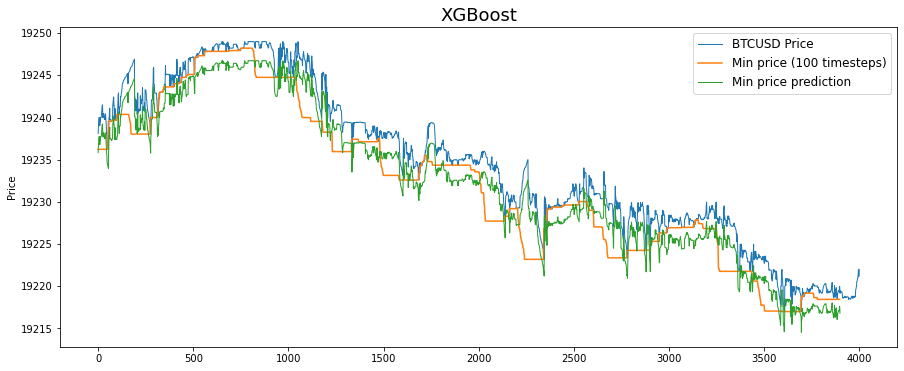

In [26]:
fig = plt.figure(figsize=(15,20))
del plot_test[0]
#Plot training data results
ax12 = fig.add_subplot(312)
ax12.plot(X_price,linewidth=1, label='BTCUSD Price')
ax12.plot(plot_test, label='Min price (100 timesteps)')
#ax12.plot(linear_plot_pred, linewidth=1, label='Linear plot pred')
ax12.plot(xgb_plot_pred, linewidth=1, label='Min price prediction')
ax12.set_title("XGBoost", fontsize=18)
ax12.set_ylabel('Price')
ax12.legend(loc="best", fontsize=12)

plt.show()